# Example queries for Demographics on COVID-19 Knowledge Graph
[Work in progress]

This notebook demonstrates how to run Cypher queries to get [Demographics from the American Community Survey 2018 5-year data](https://data.census.gov/cedsci/table?q=DP02&tid=ACSDP5Y2018.DP05) at multiple levels of geographic granularity. 

Demographics includes total population, and population by gender, race, ethnicity, and age group.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from py2neo import Graph

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Net Knowledge Graph

In [3]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

### Demographics
The following characteristics are available for demographics. Characteristics ending with Pct are values in percent, whereas all other values are counts. For details see [Subject Definitions](https://www2.census.gov/programs-surveys/acs/tech_docs/subject_definitions/2018_ACSSubjectDefinitions.pdf).

             'DP05_0001E': 'totalPopulation',
             
             # sex
             'DP05_0002E': 'male',
             'DP05_0003E': 'female',
             
             # age
             'DP05_0005E': 'age0_4',
             'DP05_0006E': 'age5_9',
             'DP05_0007E': 'age10_14',
             'DP05_0008E': 'age15_19',
             'DP05_0009E': 'age20_24',
             'DP05_0010E': 'age25_34',
             'DP05_0011E': 'age35_44',
             'DP05_0012E': 'age45_54',
             'DP05_0013E': 'age55_59',
             'DP05_0014E': 'age60_64',
             'DP05_0015E': 'age65_74',
             'DP05_0016E': 'age75_84',
             'DP05_0017E': 'age85_',

              # race
             'DP05_0037E': 'white',
             'DP05_0038E': 'blackOrAfricanAmerican',
             'DP05_0039E': 'americanIndianAndAlaskaNative',
             'DP05_0044E': 'asian',
             'DP05_0052E': 'nativeHawaiianAndOtherPacificIslander',
             'DP05_0057E': 'otherRace',
             'DP05_0058E': 'twoOrMoreRaces',
             
              # ethnicity
             'DP05_0071E': 'hispanicOrLatino',
             'DP05_0076E': 'notHispanicOrLatino'

##### Data are available at multiple levels of geographic granularity
* US County
* US Zip Code
* US Census Tract

### Get demographics by US County

If the state and county fips codes are available, demographcis can be retrieved directly.

Note, fips codes are represented as strings.

In [4]:
state_fips = '06'
county_fips = '073'

In [5]:
query = """
MATCH (d:Demographics{countyFips:$county_fips, stateFips:$state_fips})
RETURN d.stateFips, d.countyFips, d.totalPopulation, 
       d.white AS `White`, 
       d.blackOrAfricanAmerican AS `Black or African American`, 
       d.americanIndianAndAlaskaNative AS `American Indian and Alaskan Native`, 
       d.asian AS `Asian`, 
       d.nativeHawaiianAndOtherPacificIslander AS `Native Hawaiian and other Pacific Islander`,
       d.otherRace AS `other Race`,
       d.twoOrMoreRaces AS `two or more Races`
"""
df = graph.run(query, county_fips=county_fips, state_fips=state_fips).to_data_frame()
df.head()

,d.stateFips,d.countyFips,d.totalPopulation,White,Black or African American,American Indian and Alaskan Native,Asian,Native Hawaiian and other Pacific Islander,other Race,two or more Races
0,06,073,3302833,2335447,166412,20980,390418,13903,205307,170366


Example: Get the same data by traversing the KG

In [6]:
county = 'San Diego County'

In [7]:
query = """
MATCH (a:Admin2{name:$admin2})-[:HAS_DEMOGRAPHICS]-(d:Demographics)
RETURN a.name as County,
       d.white AS `White`, 
       d.blackOrAfricanAmerican AS `Black or African American`, 
       d.americanIndianAndAlaskaNative AS `American Indian and Alaskan Native`, 
       d.asian AS `Asian`, 
       d.nativeHawaiianAndOtherPacificIslander AS `Native Hawaiian and other Pacific Islander`,
       d.otherRace AS `other Race`,
       d.twoOrMoreRaces AS `two or more Races`
"""
df = graph.run(query, admin2=county).to_data_frame()
df.head()

,County,White,Black or African American,American Indian and Alaskan Native,Asian,Native Hawaiian and other Pacific Islander,other Race,two or more Races
0,San Diego County,2335447,166412,20980,390418,13903,205307,170366


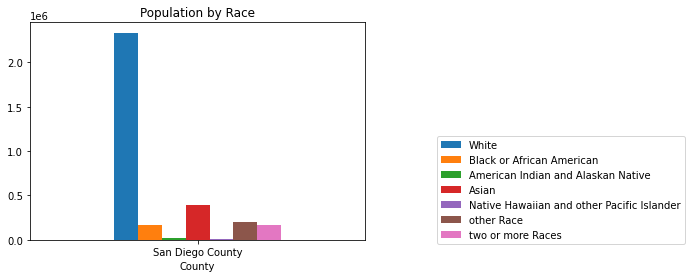

In [8]:
df.plot.bar(x='County', y=['White', 'Black or African American', 'American Indian and Alaskan Native', 
                           'Asian', 'Native Hawaiian and other Pacific Islander', 'other Race', 
                           'two or more Races'], title='Population by Race', rot=0).legend(bbox_to_anchor=(1.2, 0.5));

### Get demographics by Zip code

In [9]:
zip_code = '90210'

##### Total population and gender

In [10]:
query = """
MATCH (d:Demographics{postalCode: $postal_code})
RETURN d.postalCode, d.totalPopulation, d.male, d.female
"""
df = graph.run(query, postal_code=zip_code).to_data_frame()
df.head()

,d.postalCode,d.totalPopulation,d.male,d.female
0,90210,19909,9599,10310


##### Total population and ethnicity
Note, Zip code areas may cross city boundaries. Place names are the preferred names used by the US Postal Service.

In [11]:
place_name = 'Chula Vista'

query = """
MATCH (p:PostalCode{placeName:$place_name})-[:HAS_DEMOGRAPHICS]-(d:Demographics)
RETURN p.name as `Zip code`, p.placeName, d.totalPopulation, d.hispanicOrLatino as `Hispanic or Latino`, 
       d.notHispanicOrLatino as `not Hispanic or Latino`
"""
df = graph.run(query, place_name=place_name).to_data_frame()
df.head()

,Zip code,p.placeName,d.totalPopulation,Hispanic or Latino,not Hispanic or Latino
0,91910,Chula Vista,74297,45307,28990
1,91911,Chula Vista,85365,61189,24176
2,91913,Chula Vista,53072,24788,28284
3,91914,Chula Vista,16357,7490,8867
4,91915,Chula Vista,31740,15287,16453


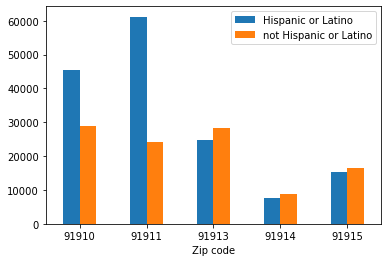

In [12]:
df.plot.bar(x='Zip code', y=['Hispanic or Latino', 'not Hispanic or Latino'], rot=0);

##### Total population and age groups

In [13]:
query = """
MATCH (p:PostalCode{name:$zip_code})-[:HAS_DEMOGRAPHICS]-(d:Demographics)
RETURN p.name, d.totalPopulation, d.age0_4, d.age5_9, d.age10_14, d.age15_19, d.age20_24, 
       d.age25_34, d.age35_44, d.age45_54, d.age55_59, d.age60_64, d.age65_74, d.age75_84, d.age85_
"""
df = graph.run(query, zip_code=zip_code).to_data_frame()
df.head()

,p.name,d.totalPopulation,d.age0_4,d.age5_9,d.age10_14,d.age15_19,d.age20_24,d.age25_34,d.age35_44,d.age45_54,d.age55_59,d.age60_64,d.age65_74,d.age75_84,d.age85_
0,90210,19909,710,1014,1482,1066,519,1956,2292,3143,1282,1093,2562,1695,1095


Check: The sum of all age groups should add up to the total population.

In [14]:
df['d.age0_4'] + df['d.age5_9'] + df['d.age10_14'] + df['d.age15_19'] + df['d.age20_24'] + df['d.age25_34'] + \
                 df['d.age35_44'] + df['d.age45_54'] + df['d.age55_59'] + df['d.age60_64'] + df['d.age65_74'] + df['d.age75_84'] + \
                 df['d.age85_']

0    19909
dtype: int64

# Get demographics by US Census tract

##### Total population and race

In [15]:
county = 'San Diego County'

In [16]:
query = """
MATCH (a:Admin2{name: $admin2})<-[:IN]-(t:Tract)-[:HAS_DEMOGRAPHICS]-(d:Demographics)
RETURN a.name AS County, 
       d.totalPopulation as Total, 
       d.white AS White, 
       d.blackOrAfricanAmerican AS `Black or African American`, 
       d.americanIndianAndAlaskaNative AS `American Indian and Alaskan Native`, 
       d.asian AS Asian,
       d.nativeHawaiianAndOtherPacificIslander AS `Native Hawaiian and other Pacific Islander`, 
       d.otherRace AS `other Race`,
       d.twoOrMoreRaces AS `two or more Races`
"""
df = graph.run(query, admin2=county).to_data_frame()
df.fillna(0, inplace=True)
df.head(10)

,County,Total,White,Black or African American,American Indian and Alaskan Native,Asian,Native Hawaiian and other Pacific Islander,other Race,two or more Races
0,San Diego County,6183,4961,74,192,48,0,774,134
1,San Diego County,5480,3486,0,24,1443,23,184,320
2,San Diego County,5872,4227,270,0,413,151,368,443
3,San Diego County,3195,2701,139,0,125,13,119,98
4,San Diego County,3963,3327,72,19,372,0,31,142
5,San Diego County,4629,4099,0,0,370,0,30,130
6,San Diego County,5616,4281,200,82,389,18,579,67
7,San Diego County,3978,2757,265,13,285,82,235,341
8,San Diego County,3187,2689,3,0,202,0,21,272
9,San Diego County,7144,5569,268,0,616,116,166,409


##### Total population and age group
This example shows how to aggregate tract-level data to the country level

In [17]:
query = """
MATCH (c:Country{iso:'US'})-[:IN]-(a1:Admin1)-[:IN]-(a2:Admin2)-[:HAS_DEMOGRAPHICS]-(d:Demographics)
RETURN c.name AS Country, sum(d.totalPopulation) AS Total, 
       sum(d.age0_4) AS age0_4, sum(d.age5_9) AS age5_9, 
       sum(d.age10_14) AS age10_14, sum(d.age15_19) AS age15_19, sum(d.age20_24) AS age20_24, 
       sum(d.age25_34) AS age25_34, sum(d.age35_44) AS age35_44, sum(d.age45_54) AS age45_54, 
       sum(d.age55_59) AS age55_59, sum(d.age60_64) AS age60_64, sum(d.age65_74) as age65_74, 
       sum(d.age75_84) AS age75_84, sum(d.age85_) AS age85_
"""
df = graph.run(query).to_data_frame()
df.head()

,Country,Total,age0_4,age5_9,age10_14,age15_19,age20_24,age25_34,age35_44,age45_54,age55_59,age60_64,age65_74,age75_84,age85_
0,United States,322903030,19836850,20311494,20817419,21204226,22286970,44567976,40763210,42589573,21611374,19675357,28535419,14497679,6205483


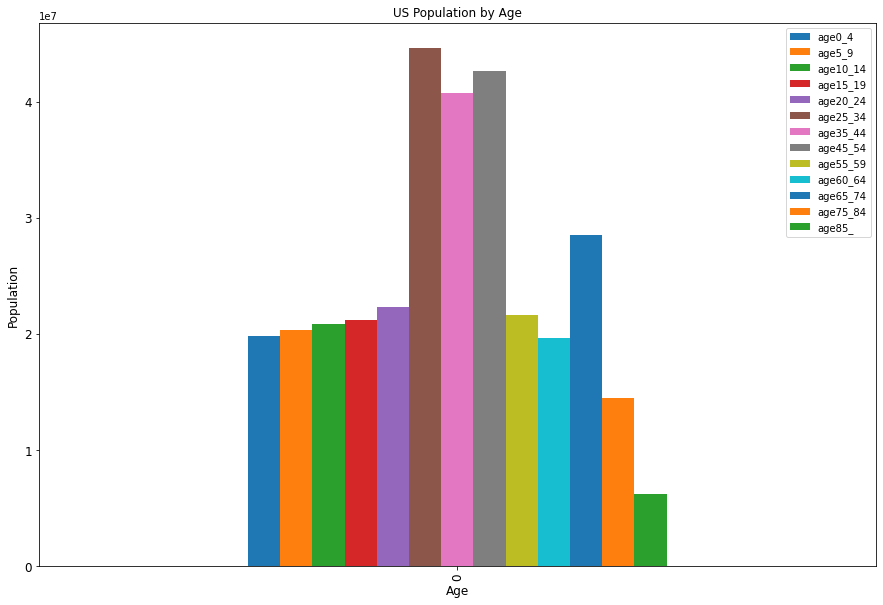

In [18]:
ax = df[['age0_4', 'age5_9', 'age10_14', 'age15_19','age20_24', 'age25_34', 'age35_44', 'age45_54', 'age55_59', \
         'age60_64', 'age65_74', 'age75_84', 'age85_']].plot(kind='bar', title ="US Population by Age", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Age", fontsize=12)
ax.set_ylabel("Population", fontsize=12)
plt.show();